# Environment

In [1]:
!nvidia-smi

Sun Feb 23 17:21:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:C1:00.0 Off |                    0 |
| 30%   28C    P8             17W /  300W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from torchinfo import summary

import medmnist
from medmnist import INFO

import src.medmnist_dataset as md
from src.architectures import architecture, VisionTransformer
from src.train import train_loop, EarlyStopping

In [3]:
# Set the global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
# Get CWD
CWD = os.getcwd()

In [ ]:
print(medmnist.__version__)

3.0.2


# Data

## Data Info

In [6]:
avaliable_datasets = ["pathmnist", "dermamnist", \
                    "octmnist", "pneumoniamnist", "breastmnist", \
                    "bloodmnist", "tissuemnist", "organamnist", \
                    "organcmnist", "organsmnist"] # "retinamnist", "chestmnist"]

In [7]:
sample_counts = []

for dataset_name in avaliable_datasets:
    
    info = INFO[dataset_name]
    print(f"-"*100)
    print(f"Dataset: {dataset_name}")
    print(f"Python: {info['python_class']}")
    print(f"Task: {info['task']}")
    print(f"Number of classes: {len(info['label'])}")
    print(f"Channels: {info['n_channels']}")
    print("Classes:")
    pprint(info['label'])

    sample_counts.append(info["n_samples"]["train"])

----------------------------------------------------------------------------------------------------
Dataset: pathmnist
Python: PathMNIST
Task: multi-class
Number of classes: 9
Channels: 3
Classes:
{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}
----------------------------------------------------------------------------------------------------
Dataset: dermamnist
Python: DermaMNIST
Task: multi-class
Number of classes: 7
Channels: 3
Classes:
{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}
----------------------------------------------------------------------------------------------------
Dataset: octmnist
Python: OCTMNIST
Task: multi-class
Number 

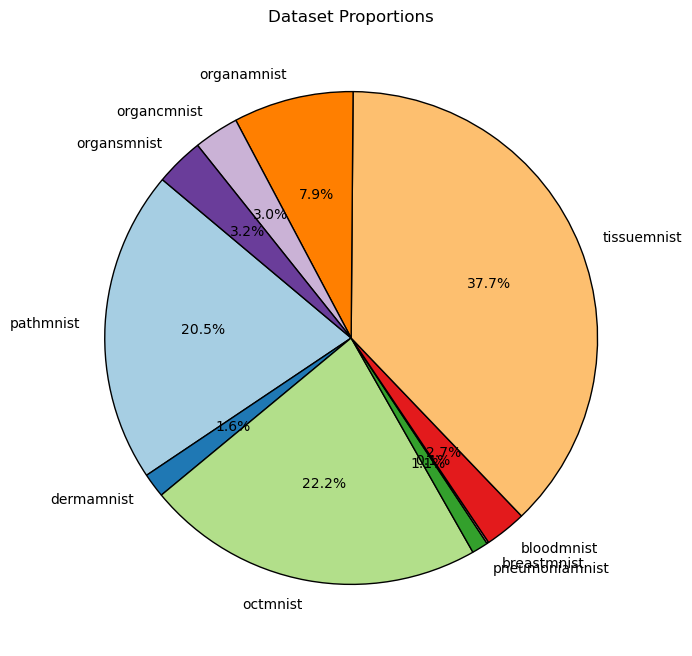

In [8]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sample_counts, labels=avaliable_datasets, autopct="%1.1f%%", startangle=140, 
        colors=plt.cm.Paired.colors, wedgeprops={"edgecolor": "black"})

# Add a title
plt.title("Dataset Proportions")

# Show the plot
plt.show()

## Data Download

In [9]:
image_size = 128 # 28, 64, 128 or 256
datasets_path = os.path.join(CWD, "datasets", str(image_size))
os.makedirs(datasets_path, exist_ok=True)

md.download(avaliable_datasets, datasets_path, image_size)

Using downloaded and verified file: /root/med-mnist/datasets/128/pathmnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/dermamnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/octmnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/pneumoniamnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/breastmnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/bloodmnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/tissuemnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/organamnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/organcmnist_128.npz
Using downloaded and verified file: /root/med-mnist/datasets/128/organsmnist_128.npz


## Dataset Unification

In [10]:
organ_datasets = ["organamnist", "organcmnist", "organsmnist"] # These are the same - have the same classes

md.unify_data(
    organ_datasets,
    are_unique_classes      = False,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"organs_{image_size}"
);

File /root/med-mnist/datasets/128/organs_128.npz already exists.


In [11]:
new_avaliable_datasets = ["organs", "pathmnist", "dermamnist", "octmnist", "pneumoniamnist", \
                            "breastmnist", "bloodmnist", "tissuemnist"]

md.unify_data(
    new_avaliable_datasets,
    are_unique_classes      = True,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"unified_{image_size}"
);

File /root/med-mnist/datasets/128/unified_128.npz already exists.


## Dataset

In [12]:
transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# Training augmentations
augmentation = v2.Compose(
    [
        transform,
        v2.RandomHorizontalFlip(p=0.5),
        v2.Pad(round(image_size/10), padding_mode="reflect"),
        v2.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(size=(image_size, image_size))
    ]
)

In [13]:
unified_dataset_path = os.path.join(datasets_path, f"unified_{image_size}.npz")

train_dataset = md.NPZDataset(
    unified_dataset_path,
    split       ="train",
    transform   =augmentation,
    mmap_mode   =None
)

validation_dataset = md.NPZDataset(
    unified_dataset_path,
    split       ="val",
    transform   =transform,
    mmap_mode   =None
)

## Data Loader

In [14]:
batch_size = 128
num_workers = 2

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size          =batch_size, 
    shuffle             =True,
    num_workers         =num_workers,
    prefetch_factor     =10,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size          =batch_size, 
    shuffle             =False,
    num_workers         =num_workers,
    prefetch_factor     =10,
)

### Test Data Loader

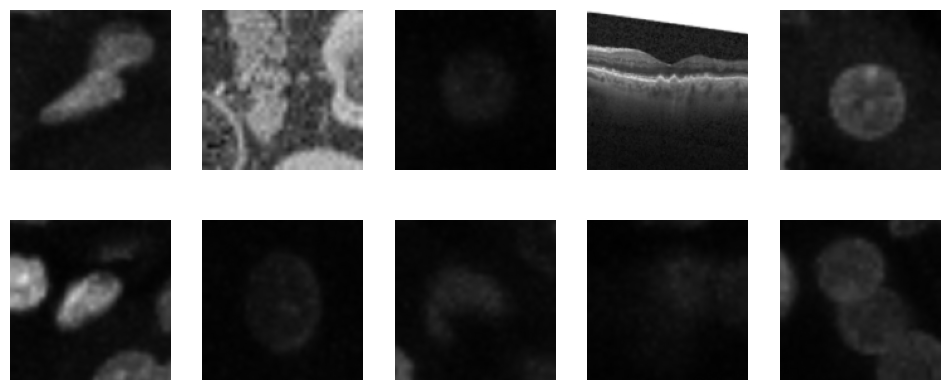

In [16]:
# Get one batch from train_loader
batch = next(iter(train_loader))
images, labels = batch  # Unpack batch

# # Denormalize for visualization
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Convert images back to [0, 1] range for visualization
images = images * std + mean  
images = torch.clamp(images, 0, 1)  # Ensure values stay in range

# Plot some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # Grid 2x5
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    ax.imshow(img)
    ax.axis("off")

plt.show()

# Training

## Parameters

In [ ]:
epochs          =50
arch            ="vit"

optimizer_name  ="Adam"
lr              =1e-4
momentum        =1
weight_decay    =1e-3

stat_to_track   ="val_loss" # "loss" "acc" "val_loss" "lr"
mode            ="min" # "min" "max"
patience        =4
delta           =5e-2
delay           = 8

In [18]:
patch_size      =4
depth           =8
num_heads       =8
mlp_ratio       =4

## Model

In [19]:
model = VisionTransformer(
    image_size          =image_size,
    patch_size          =patch_size,
    in_channels         =3, 
    num_classes         =51,
    projection_dim      =patch_size*patch_size*3,
    depth               =depth,
    num_heads           =num_heads,
    mlp_ratio           =mlp_ratio,
    dropout             =0.5
)

In [20]:
summary(model, input_size=(batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [128, 51]                 49,248
├─PatchEmbedding: 1-1                         [128, 1024, 48]           --
│    └─Patchify: 2-1                          [128, 1024, 48]           --
│    └─Linear: 2-2                            [128, 1024, 48]           2,352
├─Dropout: 1-2                                [128, 1025, 48]           --
├─Sequential: 1-3                             [128, 1025, 48]           --
│    └─TransformerBlock: 2-3                  [128, 1025, 48]           --
│    │    └─LayerNorm: 3-1                    [128, 1025, 48]           96
│    │    └─MultiHeadSelfAttention: 3-2       [128, 1025, 48]           9,408
│    │    └─Dropout: 3-3                      [128, 1025, 48]           --
│    │    └─LayerNorm: 3-4                    [128, 1025, 48]           96
│    │    └─Sequential: 3-5                   [128, 1025, 48]           18,672
│    │

In [20]:
models_dir_path = os.path.join(CWD, "models")
os.makedirs(models_dir_path, exist_ok=True)

model_save_path = os.path.join(models_dir_path, f"{arch}_d{depth}_h{num_heads}_mlr{mlp_ratio}.pth")

In [21]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer selection
if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


# Initialize the scheduler
# Uncomment the scheduler you want to use:
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Decreases LR by gamma every step_size epochs
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Adjusts LR using cosine annealing over epochs


# Early stopping
stop_fn = EarlyStopping(
    stat_to_track       =stat_to_track,
    mode                =mode,
    patience            =patience,
    delta               =delta,
    delay               =delay,
    save_path           =model_save_path
)

train_loop(
    model,
    criterion           =criterion,
    optimizer           =optimizer,
    scheduler           =scheduler,
    epochs              =epochs,
    train_loader        =train_loader,
    validation_loader   =validation_loader,
    device              =device,
    stop_fn             =stop_fn
)

stopping_report = stop_fn.report()

# If the model was not stopped by EarlyStopping, save it
if not stopping_report:
    torch.save(model.state_dict(), model_save_path)
else:
    for key in stopping_report:
        print(f"{key}: {stopping_report[key]}")

  1/50:   0%|                                                                              | 0/3427 [00:00<?, ? batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.01 GiB. GPU 0 has a total capacity of 44.42 GiB of which 3.53 GiB is free. Process 1796405 has 40.88 GiB memory in use. Of the allocated memory 39.01 GiB is allocated by PyTorch, and 1.38 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)